In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

#Utility
import random

# Preprocessing & Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile

# Evaluation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

# Optuna
import optuna
from optuna.samplers import TPESampler
from optuna import Trial

# Modeling
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd.set_option('mode.chained_assignment',  None)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train.head()

,ID,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,TRAIN_0000,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,...,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,TRAIN_0001,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,...,71.535483,71.382303,71.253604,71.092665,70.955608,70.796630,70.597550,70.565088,70.560502,70.427600
2,TRAIN_0002,634,300.0,392.0,450.0,421.0,3.0,2.9,2.9,2.9,...,71.279804,71.199570,71.144020,71.026740,70.920038,70.876723,70.710129,70.595971,70.418203,70.399578
3,TRAIN_0003,639,289.0,368.0,379.0,373.5,3.1,3.0,3.0,3.0,...,69.934615,69.884124,69.845683,69.794682,69.779813,69.614644,69.455404,69.281590,69.238689,69.133970
4,TRAIN_0004,496,306.0,353.0,358.0,355.5,3.7,3.6,3.6,3.6,...,68.313016,68.285364,68.209860,68.209458,68.040083,67.859963,67.775556,67.701456,67.504244,67.410093


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Columns: 184 entries, ID to 2022-11-28 엽록소
dtypes: float64(182), int64(1), object(1)
memory usage: 3.1+ MB


In [5]:
train.shape

(2207, 184)

In [7]:
train.isna().sum()

ID                0
착과량(int)          0
수고(m)             0
수관폭1(min)         0
수관폭2(max)         0
                 ..
2022-11-24 엽록소    0
2022-11-25 엽록소    0
2022-11-26 엽록소    0
2022-11-27 엽록소    0
2022-11-28 엽록소    0
Length: 184, dtype: int64

In [9]:
from collections import Counter

def print_mode(df, col):

    cnt = Counter(df[col])
    list_cnt = cnt.most_common(3)

    for idx, value in enumerate(list_cnt):

        print(f'{col}의 최빈값 {idx+1}순위 : {value[0]} & {value[-1]}개')

In [10]:
def print_statistics(df, col):

    max = df['착과량(int)'].max()
    min = df['착과량(int)'].min()
    mean = df['착과량(int)'].mean()
    median = df['착과량(int)'].median()

    print(f'{col}의 최대값 : {max}')
    print(f'{col}의 최소값 : {min}')
    print(f'{col}의 평균값 : {mean}')
    print(f'{col}의 중앙값 : {median}')
    print_mode(df, col)

In [11]:
def identify_hist(df, col):

    sns.histplot(data=df[col], kde=True)
    print_statistics(df, col)

착과량(int)의 최대값 : 799
착과량(int)의 최소값 : 1
착과량(int)의 평균값 : 406.22247394653374
착과량(int)의 중앙값 : 404.0
착과량(int)의 최빈값 1순위 : 300 & 9개
착과량(int)의 최빈값 2순위 : 231 & 9개
착과량(int)의 최빈값 3순위 : 632 & 9개


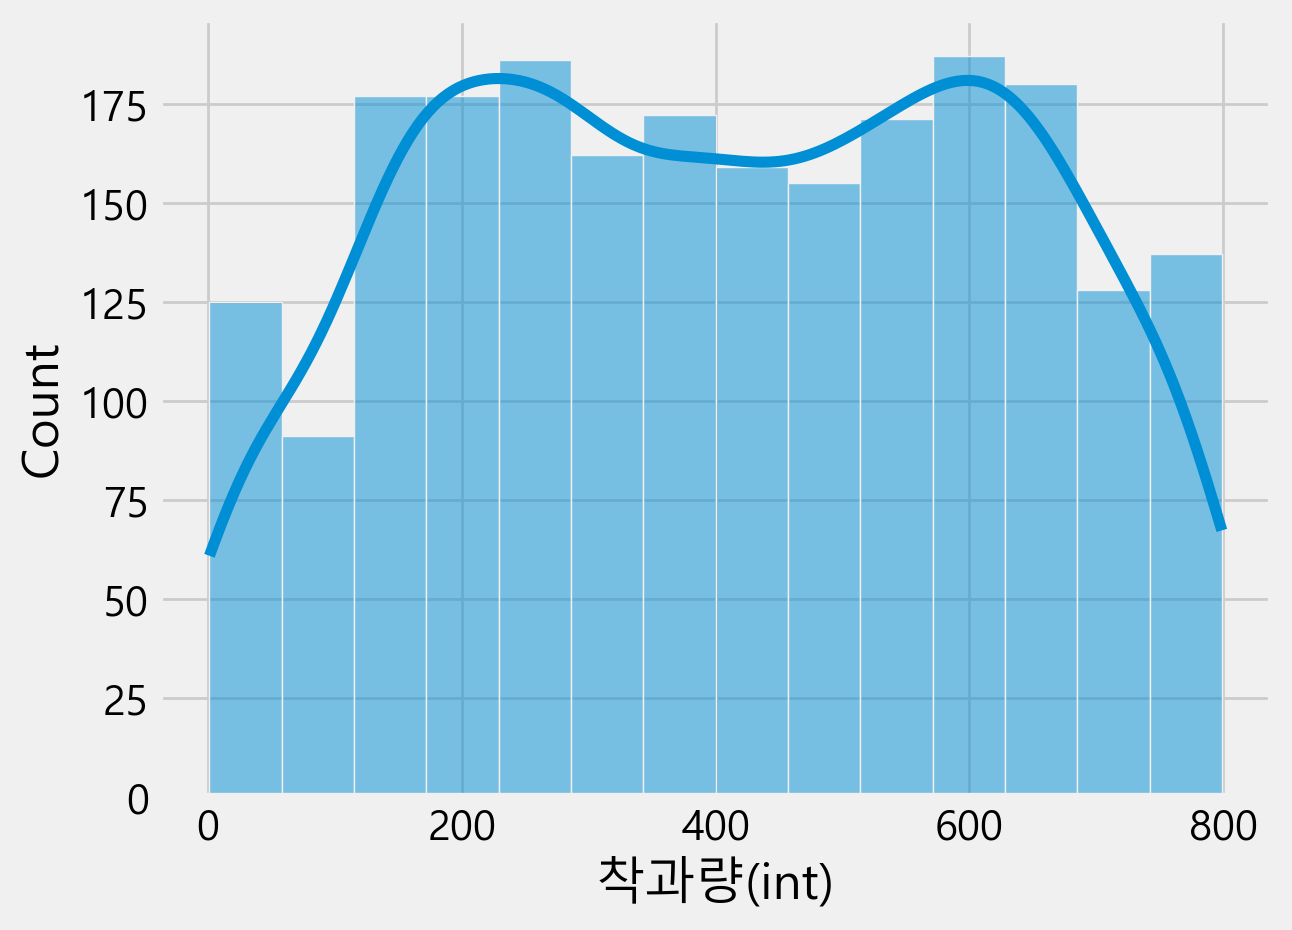

In [13]:
#시각화 설정
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

# 사용자 운영체제 확인
import os
os.name

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

identify_hist(train, '착과량(int)')

In [14]:
#train, target split
y_train = train['착과량(int)']
X_drop_list = ['ID']
X_train = train.drop(X_drop_list, axis = 1)
X_test = test.drop(["ID"], axis = 1)

In [15]:
#feature selection(target correlation limit)
high_corr = train.corr().abs().sort_values(by='착과량(int)',ascending=False).iloc[:,:1]
features_name = high_corr[high_corr['착과량(int)']>0.9].index
features_name = list(features_name)
features_name.remove('착과량(int)')
X,y = X_train.drop(['착과량(int)'], axis=1) , X_train['착과량(int)']

X_1 = X[features_name]
X_test_1 = X_test[features_name]

In [16]:
#이상치(outlier)처리
X_1 = X_1.apply(lambda x: x.clip(x.quantile(.01), x.quantile(.99)), axis=0)

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [18]:
X_train = X_train.drop(['착과량(int)'], axis=1)

In [19]:
X_train['9월_새순_mean'] = X_train.iloc[:,4:34].mean(axis = 1)
X_train['9월_새순_std'] = X_train.iloc[:,4:34].std(axis = 1)
X_train['9월_새순_var'] = X_train.iloc[:,4:34].var(axis = 1)
X_train['10월_새순_mean'] = X_train.iloc[:,34:65].mean(axis = 1)
X_train['10월_새순_std'] = X_train.iloc[:,34:65].std(axis = 1)
X_train['10월_새순_var'] = X_train.iloc[:,34:65].var(axis = 1)
X_train['11월_새순_mean'] = X_train.iloc[:,65:93].mean(axis = 1)
X_train['11월_새순_std'] = X_train.iloc[:,65:93].std(axis = 1)
X_train['11월_새순_var'] = X_train.iloc[:,65:93].var(axis = 1)
X_train['9월_엽록소_mean'] = X_train.iloc[:,93:123].mean(axis = 1)
X_train['9월_엽록소_std'] = X_train.iloc[:,93:123].std(axis = 1)
X_train['9월_엽록소_var'] = X_train.iloc[:,93:123].var(axis = 1)
X_train['10월_엽록소_mean'] = X_train.iloc[:,123:154].mean(axis = 1)
X_train['10월_엽록소_std'] = X_train.iloc[:,123:154].std(axis = 1)
X_train['10월_엽록소_var'] = X_train.iloc[:,123:154].var(axis = 1)
X_train['11월_엽록소_mean'] = X_train.iloc[:,154:182].mean(axis = 1)
X_train['11월_엽록소_std'] = X_train.iloc[:,154:182].std(axis = 1)
X_train['11월_엽록소_var'] = X_train.iloc[:,154:182].var(axis = 1)

In [20]:
X_train['새순max'] = X_train.iloc[:,4:93].max(axis=1)
X_train['새순min'] = X_train.iloc[:,4:93].min(axis=1)
X_train['엽록소max'] = X_train.iloc[:,93:182].max(axis=1)
X_train['엽록소min'] = X_train.iloc[:,93:182].min(axis=1)
X_train['새순차이'] = X_train['새순max']-X_train['새순min']
X_train['엽록소차이'] = X_train['엽록소max']-X_train['엽록소min']
X_train['수고X수관폭'] = X_train['수고(m)']*X_train['수관폭평균']
X_train['수관폭차이'] = X_train['수관폭2(max)']-X_train['수관폭1(min)']

In [21]:
for i in range(0,89):
    X_train[f'새순+엽록소_{i}'] = X_train.iloc[:,4:93].iloc[:,i]+X_train.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_train[f'새순-엽록소_{i}'] = X_train.iloc[:,4:93].iloc[:,i]-X_train.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_train[f'새순*엽록소_{i}'] = X_train.iloc[:,4:93].iloc[:,i]*X_train.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_train[f'새순/엽록소_{i}'] = X_train.iloc[:,4:93].iloc[:,i]/X_train.iloc[:,93:182].iloc[:,i]

In [22]:
X_test['9월_새순_mean'] = X_test.iloc[:,4:34].mean(axis = 1)
X_test['9월_새순_std'] = X_test.iloc[:,4:34].std(axis = 1)
X_test['9월_새순_var'] = X_test.iloc[:,4:34].var(axis = 1)
X_test['10월_새순_mean'] = X_test.iloc[:,34:65].mean(axis = 1)
X_test['10월_새순_std'] = X_test.iloc[:,34:65].std(axis = 1)
X_test['10월_새순_var'] = X_test.iloc[:,34:65].var(axis = 1)
X_test['11월_새순_mean'] = X_test.iloc[:,65:93].mean(axis = 1)
X_test['11월_새순_std'] = X_test.iloc[:,65:93].std(axis = 1)
X_test['11월_새순_var'] = X_test.iloc[:,65:93].var(axis = 1)
X_test['9월_엽록소_mean'] = X_test.iloc[:,93:123].mean(axis = 1)
X_test['9월_엽록소_std'] = X_test.iloc[:,93:123].std(axis = 1)
X_test['9월_엽록소_var'] = X_test.iloc[:,93:123].var(axis = 1)
X_test['10월_엽록소_mean'] = X_test.iloc[:,123:154].mean(axis = 1)
X_test['10월_엽록소_std'] = X_test.iloc[:,123:154].std(axis = 1)
X_test['10월_엽록소_var'] = X_test.iloc[:,123:154].var(axis = 1)
X_test['11월_엽록소_mean'] = X_test.iloc[:,154:182].mean(axis = 1)
X_test['11월_엽록소_std'] = X_test.iloc[:,154:182].std(axis = 1)
X_test['11월_엽록소_var'] = X_test.iloc[:,154:182].var(axis = 1)

In [23]:
X_test['새순max'] = X_test.iloc[:,4:93].max(axis=1)
X_test['새순min'] = X_test.iloc[:,4:93].min(axis=1)
X_test['엽록소max'] = X_test.iloc[:,93:182].max(axis=1)
X_test['엽록소min'] = X_test.iloc[:,93:182].min(axis=1)
X_test['새순차이'] = X_test['새순max']-X_test['새순min']
X_test['엽록소차이'] = X_test['엽록소max']-X_test['엽록소min']
X_test['수고X수관폭'] = X_test['수고(m)']*X_test['수관폭평균']
X_test['수관폭차이'] = X_test['수관폭2(max)']-X_test['수관폭1(min)']

In [24]:
for i in range(0,89):
    X_test[f'새순+엽록소_{i}'] = X_test.iloc[:,4:93].iloc[:,i]+X_test.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_test[f'새순-엽록소_{i}'] = X_test.iloc[:,4:93].iloc[:,i]-X_test.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_test[f'새순*엽록소_{i}'] = X_test.iloc[:,4:93].iloc[:,i]*X_test.iloc[:,93:182].iloc[:,i]
for i in range(0,89):
    X_test[f'새순/엽록소_{i}'] = X_test.iloc[:,4:93].iloc[:,i]/X_test.iloc[:,93:182].iloc[:,i]

In [25]:
X_train.shape, X_test.shape

((2207, 564), (2208, 564))

In [26]:
#base version
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

#cross_val custom version
def NMAE_CV(clf, x, y):
    pred = clf.predict(x)
    mae = np.mean(np.abs(y - pred))
    score = mae / np.mean(np.abs(y))
    return score

In [27]:
NFOLDS = 10
SEED = 22

In [28]:
numeric_features = list(X_train.columns)

In [29]:
#pipeline을 이용한 preprocessing
def remove_outlier(X, q=0.02):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

numeric_transformer = Pipeline(
    steps=[
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.02})), 
        ("scaler", MinMaxScaler()),
    ]
)
 
column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
   ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("Regressor", LGBMRegressor(objective="regression", metric="mae", random_state=SEED)),
    ]
)

In [30]:
#최적값으로 파이프라인 재설정(optuna를 이용해 preprocessing parameter tuning)
model.set_params(preprocessor__column__num__outlier__kw_args =  {'q': 0.02}, preprocessor__column__num__scaler = MinMaxScaler())

#전처리 파이프라인만 수행
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

In [31]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [32]:
#SelectPercentile을 이용해 최적 피처 수 결정
fs = SelectPercentile(percentile=13).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [33]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [34]:
X_train.to_csv('X_train_fine.csv', index = False)
X_test.to_csv('X_test_fine.csv', index = False)

In [35]:
X_2 = pd.read_csv('X_train_fine.csv')
X_test_2 = pd.read_csv('X_test_fine.csv')

In [36]:
#seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [42]:
#optuna를 이용해 hyperparameter tuning
xgb_best_params_1 = {'lambda': 0.002645916029508221,
                     'alpha': 0.06770804282734474,
                     'colsample_bytree': 0.42500508042724955,
                     'subsample': 0.7135736798352763,
                     'learning_rate': 0.0034491759962488127,
                     'n_estimators': 2538,
                     'max_depth': 4,
                     'min_child_weight': 2,
                     'objective': 'reg:squarederror',}
#                      'tree_method': 'gpu_hist',
#                      'predictor': 'gpu_predictor'}

xgb_best_params_2 = {'lambda': 0.059360963228304024,
                     'alpha': 0.9856292525135064,
                     'colsample_bytree': 0.4569397260113678,
                     'subsample': 0.4754658082470086,
                     'learning_rate': 0.0029407888288556297,
                     'n_estimators': 2020,
                     'max_depth': 11,
                     'min_child_weight': 49,
                     'objective': 'reg:squarederror',}
#                      'tree_method': 'gpu_hist',
#                      'predictor': 'gpu_predictor'}

In [43]:
#multi-kfold1(과적합 방지를 이용해 사용)
xgb_pred_1 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    xgb_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_1)):
        tr_x, tr_y = X_1.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_1.iloc[val_idx], y.iloc[val_idx]

        #사이킷 런 래퍼 XGB 학습
        xgb = XGBRegressor(**xgb_best_params_1)
        xgb.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50, eval_metric = 'mae')       
        val_pred = xgb.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        xgb_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = xgb.predict(X_test_1)
        xgb_pred_1.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(xgb_nmae)}")

4 Fold start
[0]	validation_0-mae:411.45381
[50]	validation_0-mae:346.56196
[100]	validation_0-mae:292.23183
[150]	validation_0-mae:246.54139
[200]	validation_0-mae:208.15061
[250]	validation_0-mae:175.89946
[300]	validation_0-mae:148.84540
[350]	validation_0-mae:126.24514
[400]	validation_0-mae:107.35528
[450]	validation_0-mae:91.63045
[500]	validation_0-mae:78.55709
[550]	validation_0-mae:67.99083
[600]	validation_0-mae:59.52910
[650]	validation_0-mae:52.67093
[700]	validation_0-mae:47.15709
[750]	validation_0-mae:42.79848
[800]	validation_0-mae:39.54691
[850]	validation_0-mae:37.19962
[900]	validation_0-mae:35.51451
[950]	validation_0-mae:34.32951
[1000]	validation_0-mae:33.47060
[1050]	validation_0-mae:32.81484
[1100]	validation_0-mae:32.35724
[1150]	validation_0-mae:31.99044
[1200]	validation_0-mae:31.70555
[1250]	validation_0-mae:31.47625
[1300]	validation_0-mae:31.28968
[1350]	validation_0-mae:31.16433
[1400]	validation_0-mae:31.05956
[1450]	validation_0-mae:30.97075
[1500]	vali

[1900]	validation_0-mae:29.86376
[1950]	validation_0-mae:29.84074
[2000]	validation_0-mae:29.83153
[2050]	validation_0-mae:29.83050
[2100]	validation_0-mae:29.82678
[2150]	validation_0-mae:29.82483
[2200]	validation_0-mae:29.81119
[2250]	validation_0-mae:29.80636
[2300]	validation_0-mae:29.80177
[2350]	validation_0-mae:29.80028
[2400]	validation_0-mae:29.79592
[2450]	validation_0-mae:29.78986
[2500]	validation_0-mae:29.78253
[2537]	validation_0-mae:29.76678
2/5 Fold NMAE = 0.07471809583321498
[0]	validation_0-mae:403.80390
[50]	validation_0-mae:339.76479
[100]	validation_0-mae:285.98870
[150]	validation_0-mae:240.82509
[200]	validation_0-mae:202.79802
[250]	validation_0-mae:170.82882
[300]	validation_0-mae:143.95457
[350]	validation_0-mae:121.54417
[400]	validation_0-mae:102.80868
[450]	validation_0-mae:87.14739
[500]	validation_0-mae:74.34439
[550]	validation_0-mae:63.81690
[600]	validation_0-mae:55.34512
[650]	validation_0-mae:48.70792
[700]	validation_0-mae:43.53331
[750]	validation

[900]	validation_0-mae:33.10517
[950]	validation_0-mae:32.01258
[1000]	validation_0-mae:31.22749
[1050]	validation_0-mae:30.72522
[1100]	validation_0-mae:30.36585
[1150]	validation_0-mae:30.09661
[1200]	validation_0-mae:29.88478
[1250]	validation_0-mae:29.74476
[1300]	validation_0-mae:29.65052
[1350]	validation_0-mae:29.60248
[1400]	validation_0-mae:29.56100
[1450]	validation_0-mae:29.53407
[1500]	validation_0-mae:29.50949
[1550]	validation_0-mae:29.48808
[1600]	validation_0-mae:29.48004
[1650]	validation_0-mae:29.48034
[1700]	validation_0-mae:29.46641
[1750]	validation_0-mae:29.46180
[1800]	validation_0-mae:29.45232
[1850]	validation_0-mae:29.44029
[1900]	validation_0-mae:29.44425
[1950]	validation_0-mae:29.43652
[2000]	validation_0-mae:29.44453
[2050]	validation_0-mae:29.45289
[2055]	validation_0-mae:29.45276
3/6 Fold NMAE = 0.07279284361526372
[0]	validation_0-mae:402.58755
[50]	validation_0-mae:338.61979
[100]	validation_0-mae:284.94882
[150]	validation_0-mae:239.80494
[200]	valida

In [44]:
#KFold ensemble1
xgb_pred_sum_1 = sum(xgb_pred_1)  
xgb_pred_sum_1 /= len(xgb_pred_1)
xgb_pred_sum_1

array([241.97244, 750.4108 , 150.7965 , ..., 362.65692, 241.57759,
       104.44161], dtype=float32)

In [45]:
#multi-kfold2
xgb_pred_2 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    xgb_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_2)):
        tr_x, tr_y = X_2.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_2.iloc[val_idx], y.iloc[val_idx]

        #사이킷 런 래퍼 XGB 학습
        xgb = XGBRegressor(**xgb_best_params_2)
        xgb.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50, eval_metric = 'mae')       
        val_pred = xgb.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        xgb_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = xgb.predict(X_test_2)
        xgb_pred_2.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(xgb_nmae)}")

4 Fold start
[0]	validation_0-mae:411.66049
[50]	validation_0-mae:355.63998
[100]	validation_0-mae:307.49975
[150]	validation_0-mae:266.03501
[200]	validation_0-mae:230.26860
[250]	validation_0-mae:199.43088
[300]	validation_0-mae:172.81476
[350]	validation_0-mae:149.92471
[400]	validation_0-mae:130.18699
[450]	validation_0-mae:113.33931
[500]	validation_0-mae:98.88765
[550]	validation_0-mae:86.53253
[600]	validation_0-mae:76.08599
[650]	validation_0-mae:67.39418
[700]	validation_0-mae:60.16834
[750]	validation_0-mae:54.11310
[800]	validation_0-mae:49.14913
[850]	validation_0-mae:45.10652
[900]	validation_0-mae:41.76475
[950]	validation_0-mae:39.16260
[1000]	validation_0-mae:37.20239
[1050]	validation_0-mae:35.75888
[1100]	validation_0-mae:34.72619
[1150]	validation_0-mae:33.93831
[1200]	validation_0-mae:33.36591
[1250]	validation_0-mae:32.90672
[1300]	validation_0-mae:32.51477
[1350]	validation_0-mae:32.20812
[1400]	validation_0-mae:31.95976
[1450]	validation_0-mae:31.75801
[1500]	val

[1850]	validation_0-mae:30.38844
[1900]	validation_0-mae:30.36254
[1950]	validation_0-mae:30.34379
[2000]	validation_0-mae:30.32640
[2019]	validation_0-mae:30.32221
2/5 Fold NMAE = 0.07618371346607208
[0]	validation_0-mae:404.01029
[50]	validation_0-mae:348.80337
[100]	validation_0-mae:301.18367
[150]	validation_0-mae:260.18424
[200]	validation_0-mae:224.77640
[250]	validation_0-mae:194.23804
[300]	validation_0-mae:167.86418
[350]	validation_0-mae:145.12136
[400]	validation_0-mae:125.59459
[450]	validation_0-mae:108.90643
[500]	validation_0-mae:94.51505
[550]	validation_0-mae:82.14520
[600]	validation_0-mae:71.78911
[650]	validation_0-mae:63.05679
[700]	validation_0-mae:55.83106
[750]	validation_0-mae:49.83198
[800]	validation_0-mae:45.00350
[850]	validation_0-mae:41.24373
[900]	validation_0-mae:38.27908
[950]	validation_0-mae:36.04252
[1000]	validation_0-mae:34.37353
[1050]	validation_0-mae:33.09752
[1100]	validation_0-mae:32.14008
[1150]	validation_0-mae:31.48723
[1200]	validation_0-

[1800]	validation_0-mae:29.96781
[1828]	validation_0-mae:29.96823
3/6 Fold NMAE = 0.07414944057165115
[0]	validation_0-mae:402.79393
[50]	validation_0-mae:347.61180
[100]	validation_0-mae:300.13701
[150]	validation_0-mae:259.17078
[200]	validation_0-mae:223.83859
[250]	validation_0-mae:193.32801
[300]	validation_0-mae:166.98252
[350]	validation_0-mae:144.26944
[400]	validation_0-mae:124.77278
[450]	validation_0-mae:108.03546
[500]	validation_0-mae:93.75476
[550]	validation_0-mae:81.50814
[600]	validation_0-mae:71.35674
[650]	validation_0-mae:62.91153
[700]	validation_0-mae:55.80147
[750]	validation_0-mae:49.93159
[800]	validation_0-mae:45.23463
[850]	validation_0-mae:41.55248
[900]	validation_0-mae:38.81525
[950]	validation_0-mae:36.68435
[1000]	validation_0-mae:35.12625
[1050]	validation_0-mae:33.94232
[1100]	validation_0-mae:33.00255
[1150]	validation_0-mae:32.29794
[1200]	validation_0-mae:31.80307
[1250]	validation_0-mae:31.43691
[1300]	validation_0-mae:31.20484
[1350]	validation_0-

In [46]:
#KFold ensemble2
xgb_pred_sum_2 = sum(xgb_pred_2)  
xgb_pred_sum_2 /= len(xgb_pred_2)
xgb_pred_sum_2

array([239.92996, 751.4354 , 147.44064, ..., 377.43958, 235.34543,
        93.89473], dtype=float32)

In [47]:
lgb_param = {'objective' : 'regression',
#             'device' : 'gpu',
            'metric' : 'mae'}

In [48]:
#multi-kfold1
lgb_pred_1 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    lgb_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_1)):
        tr_x, tr_y = X_1.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_1.iloc[val_idx], y.iloc[val_idx]

        lgb = LGBMRegressor(**lgb_param)
        lgb.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50, eval_metric = 'mae')
        val_pred = lgb.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        lgb_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = lgb.predict(X_test_1)
        lgb_pred_1.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(lgb_nmae)}")

4 Fold start
[50]	valid_0's l1: 31.0682
[100]	valid_0's l1: 31.2194
1/4 Fold NMAE = 0.0750938947589852
[50]	valid_0's l1: 29.9357
[100]	valid_0's l1: 30.3908
2/4 Fold NMAE = 0.07345412018872388
[50]	valid_0's l1: 31.0843
[100]	valid_0's l1: 31.7725
3/4 Fold NMAE = 0.07704386198432502
[50]	valid_0's l1: 30.0118
[100]	valid_0's l1: 30.8228
4/4 Fold NMAE = 0.07371550198927676

AVG of NMAE = 0.07482684473032772
5 Fold start
[50]	valid_0's l1: 32.0273
[100]	valid_0's l1: 32.5005
1/5 Fold NMAE = 0.07587741641418881
[50]	valid_0's l1: 30.186
[100]	valid_0's l1: 30.5449
2/5 Fold NMAE = 0.0757178970091175
[50]	valid_0's l1: 29.9635
[100]	valid_0's l1: 30.7621
3/5 Fold NMAE = 0.07299637253860815
[50]	valid_0's l1: 30.5296
[100]	valid_0's l1: 31.2729
4/5 Fold NMAE = 0.07633165140756638
[50]	valid_0's l1: 29.2525
[100]	valid_0's l1: 30.0478
5/5 Fold NMAE = 0.07147145144076841

AVG of NMAE = 0.07447895776204985
6 Fold start
[50]	valid_0's l1: 31.5488
[100]	valid_0's l1: 31.7121
1/6 Fold NMAE = 0.07

In [49]:
#KFold ensemble1
lgb_pred_sum_1 = sum(lgb_pred_1)  
lgb_pred_sum_1 /= len(lgb_pred_1)
lgb_pred_sum_1

array([238.49831599, 747.30663287, 156.58540501, ..., 360.66154915,
       245.10859987, 107.01138177])

In [50]:
#multi-kfold2
lgb_pred_2 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    lgb_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_2)):
        tr_x, tr_y = X_2.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_2.iloc[val_idx], y.iloc[val_idx]

        lgb = LGBMRegressor(**lgb_param)
        lgb.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50, eval_metric = 'mae')
        val_pred = lgb.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        lgb_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = lgb.predict(X_test_2)
        lgb_pred_2.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(lgb_nmae)}")

4 Fold start
[50]	valid_0's l1: 31.5711
[100]	valid_0's l1: 32.1593
1/4 Fold NMAE = 0.07636919813656702
[50]	valid_0's l1: 31.3333
[100]	valid_0's l1: 32.1797
2/4 Fold NMAE = 0.07582432788319474
[50]	valid_0's l1: 31.279
[100]	valid_0's l1: 32.2703
3/4 Fold NMAE = 0.07739129257716794
[50]	valid_0's l1: 30.5455
[100]	valid_0's l1: 30.7498
4/4 Fold NMAE = 0.07548923635122634

AVG of NMAE = 0.07626851373703901
5 Fold start
[50]	valid_0's l1: 32.3551
[100]	valid_0's l1: 33.0995
1/5 Fold NMAE = 0.07602220017695793
[50]	valid_0's l1: 30.8357
[100]	valid_0's l1: 31.1743
2/5 Fold NMAE = 0.07736529667395688
[50]	valid_0's l1: 30.7965
[100]	valid_0's l1: 31.6016
3/5 Fold NMAE = 0.07477936203629697
[50]	valid_0's l1: 31.5631
[100]	valid_0's l1: 32.429
4/5 Fold NMAE = 0.07898582159410032
[50]	valid_0's l1: 30.0135
[100]	valid_0's l1: 30.6581
5/5 Fold NMAE = 0.07340581643543223

AVG of NMAE = 0.07611169938334887
6 Fold start
[50]	valid_0's l1: 32.0296
[100]	valid_0's l1: 32.1912
1/6 Fold NMAE = 0.0

In [51]:
#KFold ensemble2
lgb_pred_sum_2 = sum(lgb_pred_2)  
lgb_pred_sum_2 /= len(lgb_pred_2)
lgb_pred_sum_2

array([241.71864334, 747.67113482, 152.89555874, ..., 382.48762842,
       235.6600591 ,  98.51352172])

In [53]:
#multi-kfold1
cat_pred_1 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    cat_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_1)):
        tr_x, tr_y = X_1.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_1.iloc[val_idx], y.iloc[val_idx]

        cat = CatBoostRegressor(use_best_model = True,
#                                 task_type = 'GPU',
                                iterations = 10000, 
                                eval_metric = 'MAE')
        cat.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50)
        val_pred = cat.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        cat_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = cat.predict(X_test_1)
        cat_pred_1.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(cat_nmae)}")

4 Fold start
Learning rate set to 0.013528
0:	learn: 185.9093542	test: 189.4045071	best: 189.4045071 (0)	total: 168ms	remaining: 27m 59s
50:	learn: 100.3304677	test: 103.6990421	best: 103.6990421 (50)	total: 298ms	remaining: 58.2s
100:	learn: 58.8810479	test: 61.7583240	best: 61.7583240 (100)	total: 415ms	remaining: 40.7s
150:	learn: 41.4253160	test: 44.0693813	best: 44.0693813 (150)	total: 520ms	remaining: 33.9s
200:	learn: 34.8287936	test: 37.3029583	best: 37.3029583 (200)	total: 680ms	remaining: 33.1s
250:	learn: 32.3940527	test: 34.9454804	best: 34.9454804 (250)	total: 869ms	remaining: 33.8s
300:	learn: 31.2836091	test: 33.8463612	best: 33.8463612 (300)	total: 1.1s	remaining: 35.4s
350:	learn: 30.6670342	test: 33.2752547	best: 33.2752547 (350)	total: 1.45s	remaining: 39.9s
400:	learn: 30.2402984	test: 32.8573798	best: 32.8573798 (400)	total: 1.64s	remaining: 39.2s
450:	learn: 29.9014648	test: 32.5922624	best: 32.5922624 (450)	total: 1.76s	remaining: 37.3s
500:	learn: 29.5917981	tes

550:	learn: 29.6273604	test: 31.7011893	best: 31.7011893 (550)	total: 1.5s	remaining: 25.8s
600:	learn: 29.3296450	test: 31.5753200	best: 31.5753200 (600)	total: 1.61s	remaining: 25.2s
650:	learn: 29.0387257	test: 31.4766076	best: 31.4766076 (650)	total: 1.72s	remaining: 24.7s
700:	learn: 28.7758682	test: 31.4011455	best: 31.4009063 (699)	total: 1.82s	remaining: 24.2s
750:	learn: 28.5027564	test: 31.3323686	best: 31.3323686 (750)	total: 1.96s	remaining: 24.2s
800:	learn: 28.2662785	test: 31.2686783	best: 31.2686783 (800)	total: 2.06s	remaining: 23.7s
850:	learn: 28.0201796	test: 31.2117991	best: 31.2114932 (845)	total: 2.17s	remaining: 23.4s
900:	learn: 27.7881832	test: 31.1843985	best: 31.1813704 (885)	total: 2.28s	remaining: 23s
950:	learn: 27.5729060	test: 31.1709676	best: 31.1707935 (944)	total: 2.39s	remaining: 22.7s
1000:	learn: 27.3955737	test: 31.1631666	best: 31.1480483 (978)	total: 2.52s	remaining: 22.7s
1050:	learn: 27.1964676	test: 31.1535144	best: 31.1465138 (1030)	total: 

400:	learn: 30.4828648	test: 32.2075399	best: 32.2075399 (400)	total: 866ms	remaining: 20.7s
450:	learn: 30.1517900	test: 31.8692211	best: 31.8692211 (450)	total: 1.1s	remaining: 23.3s
500:	learn: 29.8614100	test: 31.6603034	best: 31.6603034 (500)	total: 1.34s	remaining: 25.5s
550:	learn: 29.6056514	test: 31.4713497	best: 31.4713497 (550)	total: 1.48s	remaining: 25.4s
600:	learn: 29.3319757	test: 31.3020166	best: 31.3011818 (598)	total: 1.59s	remaining: 24.9s
650:	learn: 29.0582757	test: 31.1882901	best: 31.1882901 (650)	total: 1.69s	remaining: 24.3s
700:	learn: 28.7893539	test: 31.0719317	best: 31.0719317 (700)	total: 1.8s	remaining: 23.9s
750:	learn: 28.5536768	test: 30.9989884	best: 30.9940274 (748)	total: 1.91s	remaining: 23.5s
800:	learn: 28.3039583	test: 30.9627353	best: 30.9601488 (799)	total: 2.01s	remaining: 23.1s
850:	learn: 28.0896180	test: 30.9149840	best: 30.9149840 (850)	total: 2.12s	remaining: 22.8s
900:	learn: 27.8792121	test: 30.8951338	best: 30.8929749 (898)	total: 2.

600:	learn: 29.5906267	test: 29.5089913	best: 29.5079307 (593)	total: 1.61s	remaining: 25.2s
650:	learn: 29.3275116	test: 29.4770331	best: 29.4770331 (650)	total: 1.71s	remaining: 24.6s
700:	learn: 29.0328398	test: 29.4426210	best: 29.4385339 (697)	total: 1.82s	remaining: 24.1s
750:	learn: 28.7589265	test: 29.4301108	best: 29.4276231 (748)	total: 1.92s	remaining: 23.7s
800:	learn: 28.5124210	test: 29.4325216	best: 29.4217170 (760)	total: 2.03s	remaining: 23.3s
850:	learn: 28.2780450	test: 29.4074383	best: 29.4052130 (846)	total: 2.13s	remaining: 22.9s
900:	learn: 28.0787172	test: 29.3918729	best: 29.3897968 (882)	total: 2.24s	remaining: 22.6s
950:	learn: 27.8711638	test: 29.3995688	best: 29.3897968 (882)	total: 2.34s	remaining: 22.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 29.38979678
bestIteration = 882

Shrink model to first 883 iterations.
5/5 Fold NMAE = 0.07192725008893631

AVG of NMAE = 0.07504919571869953
6 Fold start
Learning rate set to 0.013754
0:	l

1900:	learn: 24.7142078	test: 30.4887105	best: 30.4804637 (1880)	total: 4.38s	remaining: 18.7s
1950:	learn: 24.5929510	test: 30.4867997	best: 30.4804637 (1880)	total: 4.49s	remaining: 18.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 30.48046366
bestIteration = 1880

Shrink model to first 1881 iterations.
2/6 Fold NMAE = 0.07555764895871883
Learning rate set to 0.013754
0:	learn: 187.2710406	test: 184.0510095	best: 184.0510095 (0)	total: 2.46ms	remaining: 24.6s
50:	learn: 100.0900487	test: 96.2542832	best: 96.2542832 (50)	total: 112ms	remaining: 21.9s
100:	learn: 58.6428279	test: 54.7435615	best: 54.7435615 (100)	total: 224ms	remaining: 22s
150:	learn: 41.3298488	test: 38.6997993	best: 38.6997993 (150)	total: 330ms	remaining: 21.5s
200:	learn: 35.0176778	test: 33.5544923	best: 33.5544923 (200)	total: 439ms	remaining: 21.4s
250:	learn: 32.7888430	test: 31.8818638	best: 31.8818638 (250)	total: 545ms	remaining: 21.2s
300:	learn: 31.7949852	test: 31.2092530	best: 31.

50:	learn: 100.0729297	test: 97.5531000	best: 97.5531000 (50)	total: 111ms	remaining: 21.7s
100:	learn: 58.5763251	test: 56.9697094	best: 56.9697094 (100)	total: 222ms	remaining: 21.7s
150:	learn: 41.4938886	test: 40.3440799	best: 40.3440799 (150)	total: 332ms	remaining: 21.7s
200:	learn: 35.2018519	test: 34.4939716	best: 34.4939716 (200)	total: 439ms	remaining: 21.4s
250:	learn: 32.9273655	test: 32.2154516	best: 32.2154516 (250)	total: 547ms	remaining: 21.2s
300:	learn: 31.8658720	test: 31.2229477	best: 31.2229477 (300)	total: 653ms	remaining: 21s
350:	learn: 31.2452705	test: 30.7160940	best: 30.7160940 (350)	total: 761ms	remaining: 20.9s
400:	learn: 30.7915227	test: 30.4314325	best: 30.4311622 (399)	total: 868ms	remaining: 20.8s
450:	learn: 30.4058162	test: 30.2470988	best: 30.2470988 (450)	total: 1.02s	remaining: 21.7s
500:	learn: 30.0991156	test: 30.1213949	best: 30.1213949 (500)	total: 1.36s	remaining: 25.7s
550:	learn: 29.7901410	test: 30.0045149	best: 30.0044088 (549)	total: 1.5

In [54]:
#KFold ensemble1
cat_pred_sum_1 = sum(cat_pred_1)  
cat_pred_sum_1 /= len(cat_pred_1)
cat_pred_sum_1

array([247.15921157, 750.77313638, 150.78909241, ..., 368.62316017,
       242.61113501, 108.28139319])

In [56]:
#multi-kfold2
cat_pred_2 = []

kfold_list = [4, 5, 6]
for kfold in kfold_list:
    print(f"{kfold} Fold start")
    i = 0
    cat_nmae = []
    kf = KFold(n_splits=kfold, random_state=42, shuffle=True)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_2)):
        tr_x, tr_y = X_2.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X_2.iloc[val_idx], y.iloc[val_idx]

        cat = CatBoostRegressor(use_best_model = True,
#                                 task_type = 'GPU',
                                iterations = 10000, 
                                eval_metric = 'MAE')
        cat.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], early_stopping_rounds = 100, verbose = 50)
        val_pred = cat.predict(val_x).astype(int)
        fold_nmae = NMAE(val_y, val_pred)
        cat_nmae.append(fold_nmae)
        print(f"{i + 1}/{kfold} Fold NMAE = {fold_nmae}")
        i += 1
        fold_pred = cat.predict(X_test_2)
        cat_pred_2.append(fold_pred)

    print(f"\nAVG of NMAE = {np.mean(cat_nmae)}")

4 Fold start
Learning rate set to 0.013528
0:	learn: 185.9063746	test: 189.3741201	best: 189.3741201 (0)	total: 5.16ms	remaining: 51.6s
50:	learn: 100.3288582	test: 103.9942298	best: 103.9942298 (50)	total: 241ms	remaining: 47.1s
100:	learn: 58.6602144	test: 61.8438704	best: 61.8438704 (100)	total: 475ms	remaining: 46.6s
150:	learn: 41.0533727	test: 43.7696745	best: 43.7696745 (150)	total: 700ms	remaining: 45.6s
200:	learn: 34.5438821	test: 36.8521359	best: 36.8521359 (200)	total: 932ms	remaining: 45.4s
250:	learn: 32.1155617	test: 34.4609080	best: 34.4609080 (250)	total: 1.19s	remaining: 46.3s
300:	learn: 31.0225127	test: 33.4639255	best: 33.4639255 (300)	total: 1.44s	remaining: 46.3s
350:	learn: 30.4346987	test: 32.9131009	best: 32.9131009 (350)	total: 1.67s	remaining: 45.8s
400:	learn: 30.0067360	test: 32.5631741	best: 32.5631741 (400)	total: 1.93s	remaining: 46.3s
450:	learn: 29.6376123	test: 32.2939640	best: 32.2939640 (450)	total: 2.21s	remaining: 46.9s
500:	learn: 29.3009332	tes

50:	learn: 99.7601193	test: 101.6241444	best: 101.6241444 (50)	total: 246ms	remaining: 48s
100:	learn: 58.1595981	test: 59.8492205	best: 59.8492205 (100)	total: 471ms	remaining: 46.2s
150:	learn: 40.6091364	test: 42.7479242	best: 42.7479242 (150)	total: 706ms	remaining: 46s
200:	learn: 34.2369054	test: 36.6690662	best: 36.6690662 (200)	total: 960ms	remaining: 46.8s
250:	learn: 31.8606658	test: 34.7302848	best: 34.7302848 (250)	total: 1.5s	remaining: 58.4s
300:	learn: 30.8796696	test: 33.9357715	best: 33.9357715 (300)	total: 1.77s	remaining: 57.2s
350:	learn: 30.3275651	test: 33.5601987	best: 33.5601987 (350)	total: 2.01s	remaining: 55.2s
400:	learn: 29.9177395	test: 33.3114352	best: 33.3114352 (400)	total: 2.24s	remaining: 53.6s
450:	learn: 29.5626979	test: 33.1137958	best: 33.1137958 (450)	total: 2.46s	remaining: 52.1s
500:	learn: 29.2154698	test: 32.9533149	best: 32.9533149 (500)	total: 2.69s	remaining: 51s
550:	learn: 28.8854879	test: 32.8054619	best: 32.8054259 (549)	total: 2.91s	r

650:	learn: 28.6781042	test: 30.8102613	best: 30.8076753 (645)	total: 2.96s	remaining: 42.5s
700:	learn: 28.3205339	test: 30.8102669	best: 30.8046728 (680)	total: 3.19s	remaining: 42.3s
750:	learn: 27.9931958	test: 30.7616483	best: 30.7616483 (750)	total: 3.41s	remaining: 42s
800:	learn: 27.6511507	test: 30.7311643	best: 30.7292779 (798)	total: 3.63s	remaining: 41.7s
850:	learn: 27.3084932	test: 30.7095326	best: 30.7046173 (845)	total: 3.85s	remaining: 41.4s
900:	learn: 26.9809904	test: 30.7062138	best: 30.6897202 (880)	total: 4.07s	remaining: 41.1s
950:	learn: 26.6776805	test: 30.6958290	best: 30.6897202 (880)	total: 4.3s	remaining: 40.9s
1000:	learn: 26.3443323	test: 30.6785715	best: 30.6654746 (981)	total: 4.52s	remaining: 40.6s
1050:	learn: 26.0413560	test: 30.6703409	best: 30.6639409 (1030)	total: 4.74s	remaining: 40.4s
1100:	learn: 25.7447292	test: 30.6953524	best: 30.6639409 (1030)	total: 4.96s	remaining: 40.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3

850:	learn: 27.3708892	test: 30.8539699	best: 30.8441398 (841)	total: 4.2s	remaining: 45.1s
900:	learn: 27.0778105	test: 30.8063680	best: 30.8014321 (890)	total: 4.42s	remaining: 44.7s
950:	learn: 26.7919967	test: 30.7516822	best: 30.7499774 (940)	total: 4.65s	remaining: 44.2s
1000:	learn: 26.4921647	test: 30.7070398	best: 30.7069641 (998)	total: 4.87s	remaining: 43.8s
1050:	learn: 26.2079190	test: 30.6889399	best: 30.6846664 (1036)	total: 5.1s	remaining: 43.4s
1100:	learn: 25.9419668	test: 30.6695810	best: 30.6695810 (1100)	total: 5.32s	remaining: 43s
1150:	learn: 25.6824339	test: 30.6489055	best: 30.6464750 (1142)	total: 5.55s	remaining: 42.6s
1200:	learn: 25.4448661	test: 30.6555820	best: 30.6373713 (1183)	total: 5.77s	remaining: 42.3s
1250:	learn: 25.2017480	test: 30.6219916	best: 30.6191659 (1240)	total: 5.99s	remaining: 41.9s
1300:	learn: 24.9602199	test: 30.5871354	best: 30.5871354 (1300)	total: 6.21s	remaining: 41.6s
1350:	learn: 24.7099185	test: 30.5915351	best: 30.5753969 (13

700:	learn: 28.4763735	test: 30.0654732	best: 30.0365465 (681)	total: 3.46s	remaining: 45.8s
750:	learn: 28.1686877	test: 30.0324227	best: 30.0324227 (750)	total: 3.69s	remaining: 45.4s
800:	learn: 27.8556533	test: 30.0256684	best: 30.0221841 (786)	total: 3.91s	remaining: 44.9s
850:	learn: 27.5428312	test: 30.0161171	best: 30.0155580 (838)	total: 4.13s	remaining: 44.4s
900:	learn: 27.2686436	test: 30.0328274	best: 30.0155185 (851)	total: 4.35s	remaining: 44s
950:	learn: 26.9566060	test: 30.0250973	best: 30.0155185 (851)	total: 4.58s	remaining: 43.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 30.01551852
bestIteration = 851

Shrink model to first 852 iterations.
6/6 Fold NMAE = 0.07288465614072269

AVG of NMAE = 0.07546869204590395


In [57]:
#KFold ensemble2
cat_pred_sum_2 = sum(cat_pred_2)  
cat_pred_sum_2 /= len(cat_pred_2)
cat_pred_sum_2

array([244.82379521, 755.2612594 , 151.11177367, ..., 375.57366443,
       228.73155068,  87.70284256])

In [58]:
submission1 = submission.copy()
submission2 = submission.copy()

submission1['착과량(int)'] = xgb_pred_sum_1*0.4 + lgb_pred_sum_1*0.4 + cat_pred_sum_1*0.2
submission2['착과량(int)'] = xgb_pred_sum_2*0.4 + lgb_pred_sum_2*0.4 + cat_pred_sum_2*0.2

In [59]:
submission['착과량(int)'] = submission1['착과량(int)']*0.8 + submission2['착과량(int)']*0.2

In [63]:
submission

,ID,착과량(int)
0,TEST_0000,241.620958
1,TEST_0001,749.532273
2,TEST_0002,152.559831
3,TEST_0003,445.571701
4,TEST_0004,684.128585
...,...,...
2203,TEST_2203,752.443625
2204,TEST_2204,337.058102
2205,TEST_2205,366.258744
2206,TEST_2206,241.387063


In [64]:
submission.to_csv('ensemble.csv', index=False)